In [1]:
import sys
from collections import Counter

import numpy as np
import pandas as pd
from scipy import stats
from tqdm.notebook import tqdm
import optuna
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

sys.path.append('../src')
import const
from metrics import micro_f1_similarity, row_wise_micro_averaged_f1_score

pd.options.display.max_rows = 120

In [2]:
valid_df = pd.read_csv('../data/input/train_soundscape_labels.csv')
use_idx = valid_df[~valid_df["audio_id"].isin([7019, 7954, 14473])].index
# use_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473, 2782, 7843, 20152, 28933, 54955])].index
drop_idx = valid_df[valid_df["audio_id"].isin([7019, 7954, 14473])].index
valid_df = valid_df.iloc[use_idx].reset_index(drop=True)

val_y_labels = valid_df["birds"].tolist()

all_diff_scores = {}

In [3]:
def fill_dropped(dropped_array, drop_idx):
    filled_array = np.zeros(
        (len(dropped_array) + len(drop_idx), dropped_array.shape[1])
    )
    idx_array = np.arange(len(filled_array))
    use_idx = np.delete(idx_array, drop_idx)
    filled_array[use_idx, :] = dropped_array
    return filled_array

In [4]:
def extract_label(preds, th=0.5):
    events = preds >= th
    nocall_col = np.zeros((len(preds), 1)).astype(bool)
    nocall_col[events.sum(1) == 0] = True
    events = np.concatenate([events, nocall_col], axis=1)
    
    predict_labels = []
    for i in range(len(events)):
        event = events[i, :]
        labels = np.argwhere(event).reshape(-1).tolist()
        
        row_labels = []
        for label in labels:
            row_labels.append(const.INV_BIRD_CODE[label])
        predict_labels.append(" ".join(row_labels))

    return predict_labels

In [5]:
def set_audio_base_score(pred_labels, df):
    score_dict = {}
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        score = row_wise_micro_averaged_f1_score(audio_df["birds"], np.array(pred_labels)[idxs])
        score_dict[audio_id] = score
        
    return score_dict

def get_audio_score(pred_labels, df, score_dict):
    diff_scores = {}

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        score = row_wise_micro_averaged_f1_score(audio_df["birds"], np.array(pred_labels)[idxs])
        base_score = score_dict[audio_id]

        print(f"{audio_id}: {score:.4f} [{score - base_score:.3f}]")
        diff_scores[audio_id] = score - base_score
        
    return diff_scores

In [43]:
# oof4 = np.load("../logs/exp_004_20210409202215_0.701/oof.npy")
# oof10 = np.load("../logs/exp_010_20210412203406_0.684/oof.npy")
# oof11 = np.load("../logs/exp_011_20210413092718_0.710/oof.npy")
# oof12 = np.load("../logs/exp_012_20210413202510_0.700/oof.npy")
# oof20 = np.load("../logs/exp_020_20210420203023_0.698/oof.npy")
# oof21 = np.load("../logs/exp_021_20210421105635_0.701/oof.npy")
# oof22 = np.load("../logs/exp_022_20210421213519_0.712/oof.npy")
# oof23 = np.load("../logs/exp_023_20210422072541_0.696/oof.npy")
# oof24 = np.load("../logs/exp_024_20210422215622_0.684/oof.npy")
# oof25 = np.load("../logs/exp_025_20210423142123_0.684/oof.npy")
# oof28 = np.load("../logs/exp_028_20210425165254_0.671/oof.npy")
# oof28 = np.load("../logs/exp_028_20210425165254_0.671/oof.npy")
# # oof29 = np.load("../logs/exp_029_20210425212038_0.675/oof.npy")
# # oof32 = np.load("../logs/exp_032_20210426185313_0.684/oof.npy")
# # oof33 = np.load("../logs/exp_033_20210426230524_0.701/oof.npy")
# # oof34 = np.load("../logs/exp_034_20210427025324_0.686/oof.npy")
# # oof35 = np.load("../logs/exp_035_20210427085305_0.690/oof.npy")

# oof40 = np.load("../logs/exp_040_20210428095746_0.696/oof.npy")
# oof41 = np.load("../logs/exp_041_20210428173715_0.689/oof.npy")
# oof42 = np.load("../logs/exp_042_20210429120526_0.692/oof.npy")
# oof43 = np.load("../logs/exp_043_20210429195623_0.697/oof.npy")
# oof44 = np.load("../logs/exp_044_20210429235301_0.707/oof.npy")
# oof45 = np.load("../logs/exp_045_20210430131333_0.695/oof.npy")
# oof50 = np.load("../logs/exp_050_20210502230529_0.679/oof.npy")
# oof51 = np.load("../logs/exp_051_20210503030848_0.694/oof.npy")
# oof52 = np.load("../logs/exp_052_20210503093904_0.692/oof.npy")

# oof54 = np.load("../logs/exp_054_20210503234704_0.685/oof.npy")
# oof55 = np.load("../logs/exp_055_20210504024705_0.693/oof.npy")
# oof55 = oof54 * 0.5 + oof55 * 0.5

# oof56 = np.load("../logs/exp_056_20210504114210_0.697/oof.npy")
# oof57 = np.load("../logs/exp_057_20210504153605_0.690/oof.npy")
# oof58 = np.load("../logs/exp_058_20210504202445_0.679/oof.npy")
# oof60 = np.load("../logs/exp_060_20210505181921_0.706/oof.npy")
# oof61 = np.load("../logs/exp_061_20210505232548_0.656/oof.npy")
# oof62 = np.load("../logs/exp_062_20210506032156_0.648/oof.npy")
# oof65 = np.load("../logs/exp_065_20210507102634_0.640/oof.npy")
# oof65 = fill_dropped(oof65, drop_idx)
# oof66 = np.load("../logs/exp_066_20210507141914_0.637/oof.npy")
# oof66 = fill_dropped(oof66, drop_idx)
# oof67 = np.load("../logs/exp_067_20210507230447_0.629/oof.npy")
# oof68 = np.load("../logs/exp_068_20210508025654_0.620/oof.npy")
# oof74 = np.load("../logs/exp_074_20210509223155_3.172/oof.npy")
# oof74 = fill_dropped(oof74, drop_idx)
# oof76 = np.load("../logs/exp_076_20210511000515_0.629/oof.npy")
# oof76 = fill_dropped(oof76, drop_idx)
# oof77 = np.load("../logs/exp_077_20210511035734_0.629/oof.npy")
# oof77 = fill_dropped(oof77, drop_idx)
# oof78 = np.load("../logs/exp_078_20210511074917_0.633/oof.npy")
# oof78 = fill_dropped(oof78, drop_idx)
# oof81 = np.load("../logs/exp_081_20210511225340_0.636/oof.npy")
# oof81 = fill_dropped(oof81, drop_idx)
# oof82 = np.load("../logs/exp_082_20210512024531_0.625/oof.npy")
# oof82 = fill_dropped(oof82, drop_idx)
# oof86 = np.load("../logs/exp_086_20210512183544_0.632/oof.npy")
# oof86 = fill_dropped(oof86, drop_idx)
# oof87 = np.load("../logs/exp_087_20210512231955_0.619/oof.npy")
# oof87 = fill_dropped(oof87, drop_idx)
# oof88 = np.load("../logs/exp_088_20210513031332_0.628/oof.npy")
# oof88 = fill_dropped(oof88, drop_idx)
# oof89 = np.load("../logs/exp_089_20210513093810_0.627/oof.npy")
# oof89 = fill_dropped(oof89, drop_idx)
# oof91 = np.load("../logs/exp_091_20210514120344_0.639/oof.npy")
# oof91 = fill_dropped(oof91, drop_idx)
# oof92 = np.load("../logs/exp_092_20210514160253_0.650/oof.npy")
# oof92 = fill_dropped(oof92, drop_idx)
# oof93 = np.load("../logs/exp_093_20210514195743_0.630/oof.npy")
# oof93 = fill_dropped(oof93, drop_idx)
# oof95 = np.load("../logs/exp_095_20210515002049_0.633/oof.npy")
# oof95 = fill_dropped(oof95, drop_idx)
# oof96 = np.load("../logs/exp_096_20210515042121_0.636/oof.npy")
# oof96 = fill_dropped(oof96, drop_idx)
# oof97 = np.load("../logs/exp_097_20210515081329_0.653/oof.npy")
# oof97 = fill_dropped(oof97, drop_idx)
# oof100 = np.load("../logs/exp_100_20210516094037_0.620/oof.npy")
# oof100 = fill_dropped(oof100, drop_idx)
# oof101 = np.load("../logs/exp_101_20210516134723_0.650/oof.npy")
# oof101 = fill_dropped(oof101, drop_idx)
# oof102 = np.load("../logs/exp_102_20210516214845_0.620/oof.npy")
# oof102 = fill_dropped(oof102, drop_idx)
# oof106 = np.load("../logs/exp_106_20210519022652_0.601/oof.npy")
# oof106 = fill_dropped(oof106, drop_idx)
oof112 = np.load("../logs/exp_112_20210520045116_0.638/oof.npy")
oof112 = fill_dropped(oof112, drop_idx)
oof114 = np.load("../logs/exp_114_20210520192947_0.650/oof.npy")
oof114 = fill_dropped(oof114, drop_idx)
oof115 = np.load("../logs/exp_115_20210520232446_0.631/oof.npy")
oof115 = fill_dropped(oof115, drop_idx)
oof116 = np.load("../logs/exp_116_20210521031557_0.641/oof.npy")
oof116 = fill_dropped(oof116, drop_idx)
oof117 = np.load("../logs/exp_117_20210521070917_0.640/oof.npy")
oof117 = fill_dropped(oof117, drop_idx)
oof118 = np.load("../logs/exp_118_20210521110036_0.653/oof.npy")
oof118 = fill_dropped(oof118, drop_idx)
oof121 = np.load("../logs/exp_121_20210521215739_0.637/oof.npy")
oof121 = fill_dropped(oof121, drop_idx)

oof129 = np.load("../logs/exp_129_20210523145254_0.641/oof.npy")
oof129 = fill_dropped(oof129, drop_idx)
oof131 = np.load("../logs/exp_131_20210524005536_0.641/oof.npy")
oof131 = fill_dropped(oof131, drop_idx)
oof132 = np.load("../logs/exp_132_20210524061303_0.623/oof.npy")
oof132 = fill_dropped(oof132, drop_idx)
oof133 = np.load("../logs/exp_133_20210524105841_0.630/oof.npy")
oof133 = fill_dropped(oof133, drop_idx)
oof134 = np.load("../logs/exp_134_20210524160839_0.636/oof.npy")
oof134 = fill_dropped(oof134, drop_idx)
oof135 = np.load("../logs/exp_135_20210524214504_0.649/oof.npy")
oof135 = fill_dropped(oof135, drop_idx)
oof136 = np.load("../logs/exp_136_20210525032138_0.623/oof.npy")
oof136 = fill_dropped(oof136, drop_idx)

# nocall classification
oof59 = np.load("../logs/exp_059_20210505100513_0.666/oof.npy")
oof70 = np.load("../logs/exp_070_20210508193023_0.882/oof.npy")
oof79 = np.load("../logs/exp_079_20210511132329_0.874/oof.npy")
oof83 = np.load("../logs/exp_083_20210512081958_0.827/oof.npy")
oof99 = np.load("../logs/exp_099_20210515202257_0.859/oof.npy")

## BaseScore

In [7]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [8]:
base_oof_labels = extract_label(oof, th=0.33)
score_dict = set_audio_base_score(base_oof_labels, valid_df)
np.mean(list(score_dict.values()))

0.6880555555555553

## All nocall

In [9]:
oof_labels = ["nocall"] * len(valid_df)
score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
score

0.5769607843137236

## Simple Average

In [54]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
    oof132[np.newaxis, :, :],
#     oof133[np.newaxis, :, :],
#     oof134[np.newaxis, :, :],
    oof135[np.newaxis, :, :],
    oof136[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [55]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [56]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7017 (th=0.26)

best score: 0.6986 (th=0.26)


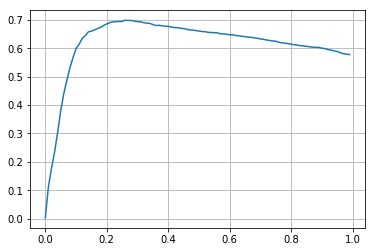

In [57]:
plt.plot(th_list, scores)
plt.grid()

In [58]:
diff_scores0 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg"] = diff_scores0

2782: 0.2747 [0.032]
7843: 0.9750 [0.008]
10534: 0.6778 [-0.008]
11254: 0.8889 [0.006]
18003: 0.6361 [0.033]
20152: 0.9417 [0.000]
21767: 0.3306 [0.025]
26709: 0.5194 [-0.008]
26746: 0.6778 [0.039]
28933: 0.4458 [0.033]
31928: 0.9667 [-0.017]
42907: 0.7333 [0.017]
44957: 0.7389 [0.000]
50878: 0.8167 [-0.025]
51010: 0.4889 [0.028]
54955: 0.8500 [0.008]
57610: 0.9139 [0.008]


## Simple Average + nocall classification

In [15]:
concat_oof = np.concatenate([
#     oof112[np.newaxis, :, :],
#     oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]
# nc_oof = oof79 * 0.5 + oof83 * 0.5
nc_oof = oof99

In [16]:
for idx in range(len(oof)):
    nocall_p = 1 - nc_oof[idx]
    if nocall_p <= 0.1:
        col1_idx = np.argsort(oof[idx, :])[-1:]
        oof[idx, col1_idx] *= 5

In [17]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(300):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [18]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score:0.7408 (th=0.33)

best score: 0.6957 (th=1.37)


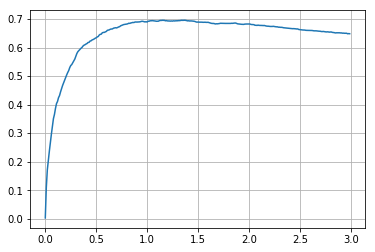

In [19]:
plt.plot(th_list, scores)
plt.grid()

In [20]:
diff_scores1 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg_nc"] = diff_scores1

2782: 0.2497 [0.007]
7843: 0.9667 [0.000]
10534: 0.6278 [-0.058]
11254: 0.8917 [0.008]
18003: 0.6028 [0.000]
20152: 0.9583 [0.017]
21767: 0.3444 [0.039]
26709: 0.5500 [0.022]
26746: 0.6861 [0.047]
28933: 0.4319 [0.019]
31928: 0.9833 [0.000]
42907: 0.7250 [0.008]
44957: 0.7389 [0.000]
50878: 0.8250 [-0.017]
51010: 0.4972 [0.036]
54955: 0.8500 [0.008]
57610: 0.8972 [-0.008]


## Voting

In [21]:
def voting(pred_labels_list, vote_lim):
    final_oof_labels = []
    
    for idx in range(len(use_idx)):
        birds = []

        for labels in oof_labels_list:
            birds.extend(labels[idx].split(" "))

        birds = [x for x in birds if "nocall" != x and "" != x]
        count_birds = Counter(birds)

        final_birds = []
        for key, value in count_birds.items():
            if value >= vote_lim:
                final_birds.append(key)

        if len(final_birds) == 0:
            final_birds.append("nocall")

        final_oof_labels.append(" ".join(final_birds))

    return final_oof_labels

In [22]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_vote_lim = 0
best_final_labels = None

# for vote_lim in range(1, len(oof_labels_list)):
for vote_lim in [1, 2, 3, 4, 5, 6]:
    for i in tqdm(range(100)):
        th = i / 100.0
        
        oof112_labels = extract_label(oof112[use_idx, :], th)
        oof114_labels = extract_label(oof114[use_idx, :], th)
        oof115_labels = extract_label(oof115[use_idx, :], th)
        oof116_labels = extract_label(oof116[use_idx, :], th)
        oof117_labels = extract_label(oof117[use_idx, :], th)
        oof118_labels = extract_label(oof118[use_idx, :], th)
        oof121_labels = extract_label(oof121[use_idx, :], th)
        oof129_labels = extract_label(oof129[use_idx, :], th)
        oof131_labels = extract_label(oof131[use_idx, :], th)

        oof_labels_list = [
#             oof112_labels,
#             oof114_labels,
            oof115_labels,
            oof116_labels,
            oof117_labels,
            oof118_labels,
            oof129_labels,
            oof131_labels,
        ]

        final_oof_labels = voting(oof_labels_list, vote_lim)

        score = row_wise_micro_averaged_f1_score(val_y_labels, final_oof_labels)
            
        if best_score < score:
            best_score = score
            best_th = th
            best_vote_lim = vote_lim
            best_final_labels = final_oof_labels
                
        th_list.append(th)
        scores.append(score)

In [23]:
best_score   # 0.7430

0.6984150326797361

In [24]:
best_th

0.18

In [25]:
best_vote_lim

3

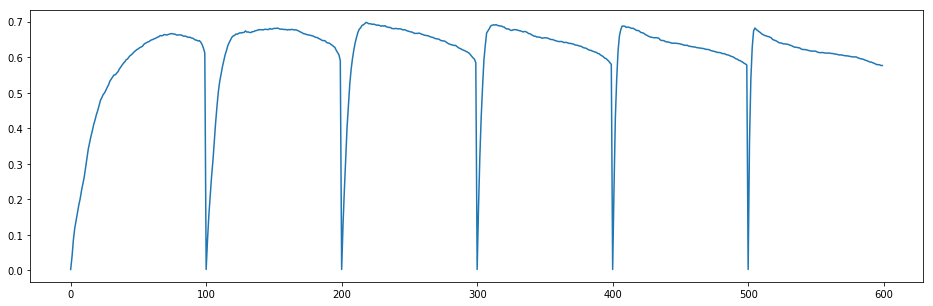

In [26]:
plt.figure(figsize=(16, 5))
plt.plot(scores)

In [27]:
diff_scores2 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["voting"] = diff_scores2

2782: 0.3008 [0.058]
7843: 0.9750 [0.008]
10534: 0.6583 [-0.028]
11254: 0.8639 [-0.019]
18003: 0.6444 [0.042]
20152: 0.8500 [-0.092]
21767: 0.3556 [0.050]
26709: 0.5444 [0.017]
26746: 0.7028 [0.064]
28933: 0.4750 [0.062]
31928: 0.9917 [0.008]
42907: 0.7639 [0.047]
44957: 0.7306 [-0.008]
50878: 0.7917 [-0.050]
51010: 0.4861 [0.025]
54955: 0.8500 [0.008]
57610: 0.8889 [-0.017]


## Simple Average > PostProcess_v12

In [108]:
def post_process_site_12(preds, threshold=0.5, maxpreds=3):
    preds = preds * (preds >= threshold)   # remove preds < threshold
    
#     next_preds = np.concatenate([preds[1:], preds[-1:]])  # pred corresponding to next window
#     prev_preds = np.concatenate([preds[:1], preds[:-1]])  # pred corresponding to previous window

    next_preds = np.concatenate([preds[1:], np.zeros((1, preds.shape[-1]))])  # pred corresponding to next window
    prev_preds = np.concatenate([np.zeros((1, preds.shape[-1])), preds[:-1]])  # pred corresponding to previous window
    
    score = preds + next_preds + prev_preds  # Aggregating
    
    n_birds = (score >= threshold - 1e-5).sum(-1)   # threshold ?
    n_birds = np.clip(n_birds, 0, maxpreds)  # keep at most maxpreds birds
    
    labels = [np.argsort(- score[i])[:n_birds[i]].tolist() for i in range(len(preds))]
#     class_labels = [" ".join([CLASSES[l] for l in label]) for label in labels]
    class_labels = [" ".join([const.INV_BIRD_CODE[l] for l in label]) if len(label) > 0 else "nocall" for label in labels]
    
    return class_labels

In [109]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
    oof132[np.newaxis, :, :],
#     oof133[np.newaxis, :, :],
#     oof134[np.newaxis, :, :],
    oof135[np.newaxis, :, :],
    oof136[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [110]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0
    
    oof_labels = post_process_site_12(oof, threshold=th, maxpreds=3)
#     oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [111]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score: 0.7082 (th=0.27)

best score: 0.6772 (th=0.32)


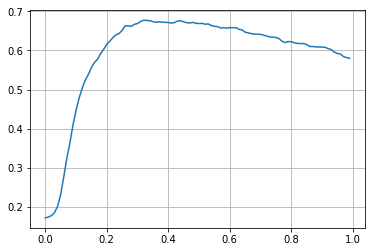

In [112]:
plt.plot(th_list, scores)
plt.grid()

In [113]:
diff_scores3 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg_postv12"] = diff_scores3

2782: 0.3478 [0.105]
7843: 0.9667 [0.000]
10534: 0.5167 [-0.169]
11254: 0.7583 [-0.125]
18003: 0.6972 [0.094]
20152: 0.8917 [-0.050]
21767: 0.3917 [0.086]
26709: 0.5333 [0.006]
26746: 0.6583 [0.019]
28933: 0.5236 [0.111]
31928: 0.9750 [-0.008]
42907: 0.7250 [0.008]
44957: 0.7389 [0.000]
50878: 0.7000 [-0.142]
51010: 0.4778 [0.017]
54955: 0.8000 [-0.042]
57610: 0.8111 [-0.094]


## PostProcess_v2 -> Simple Avg

In [34]:
def post_process_v2(preds, df, c=2, q=0.99, w=1.5):
    if "file_id" not in df.columns:
        df["file_id"] = df["audio_id"].astype(str) + "_" + df["site"]

    post_weight_dict = {}
    init_weight = np.ones(len(const.BIRD_CODE) - 1)

    for i, file_id in enumerate(df["file_id"].unique()):
        file_id_idx = df[df["file_id"] == file_id].index.values
        sum_ = np.sum(preds[file_id_idx, :], axis=0)
        sum_ = sum_ / np.max(sum_)
        quantile_ = np.quantile(sum_, q)
        
        
        post_weight = init_weight.copy()
        for bc in np.argsort(sum_)[::-1]:
            v = sum_[bc]
            if v >= (quantile_ * c):
                post_weight[bc] = w
            else:
                break
                
        post_weight_dict[file_id] = post_weight
        
    post_preds = preds.copy()
    for idx in df.index:
        file_id = df.loc[idx, "file_id"]
        post_weight = post_weight_dict[file_id]
        post_preds[idx, :] = preds[idx, :] * post_weight
    
    return post_preds

In [35]:
c=2.0
q=0.99
w=2.0

post_oof112 = post_process_v2(oof112, valid_df, c, q, w)
post_oof114 = post_process_v2(oof114, valid_df, c, q, w)
post_oof115 = post_process_v2(oof115, valid_df, c, q, w)
post_oof116 = post_process_v2(oof116, valid_df, c, q, w)
post_oof117 = post_process_v2(oof117, valid_df, c, q, w)
post_oof118 = post_process_v2(oof118, valid_df, c, q, w)
post_oof121 = post_process_v2(oof121, valid_df, c, q, w)
post_oof129 = post_process_v2(oof129, valid_df, c, q, w)
post_oof131 = post_process_v2(oof131, valid_df, c, q, w)

concat_oof = np.concatenate([
#     post_oof112[np.newaxis, :, :],
#     post_oof114[np.newaxis, :, :],
    post_oof115[np.newaxis, :, :],
    post_oof116[np.newaxis, :, :],
    post_oof117[np.newaxis, :, :],
    post_oof118[np.newaxis, :, :],
    post_oof129[np.newaxis, :, :],
    post_oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [36]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [37]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7333 (th=0.28)

best score: 0.6989 (th=0.42)


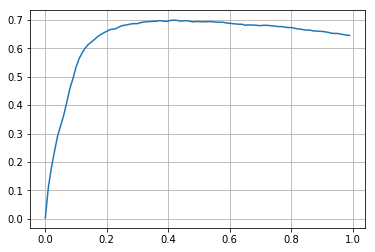

In [38]:
plt.plot(th_list, scores)
plt.grid()

In [39]:
diff_scores4 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_avg"] = diff_scores4

2782: 0.2886 [0.046]
7843: 0.9667 [0.000]
10534: 0.6528 [-0.033]
11254: 0.9000 [0.017]
18003: 0.6361 [0.033]
20152: 0.8917 [-0.050]
21767: 0.3833 [0.078]
26709: 0.5139 [-0.014]
26746: 0.6861 [0.047]
28933: 0.4542 [0.042]
31928: 0.9750 [-0.008]
42907: 0.6833 [-0.033]
44957: 0.7722 [0.033]
50878: 0.8750 [0.033]
51010: 0.4556 [-0.006]
54955: 0.8333 [-0.008]
57610: 0.9139 [0.008]


## PostProcess_v3 -> Simple Avg

In [40]:
def post_process_v3(preds, df):
    if "file_id" not in df.columns:
        df["file_id"] = df["audio_id"].astype(str) + "_" + df["site"]
    
    modified_preds = np.zeros_like(preds)
    for i, file_id in enumerate(df["file_id"].unique()):
        file_id_idx = df[df["file_id"] == file_id].index.values
        mean_ = np.mean(preds[file_id_idx, :], axis=0)
        
        if mean_.std() >= 5e-3:
            weight = (mean_ - mean_.mean()) / mean_.std()
            modified_preds[file_id_idx, :] = preds[file_id_idx, :] * weight
        else:
            modified_preds[file_id_idx, :] = preds[file_id_idx, :]
    
    return modified_preds

In [41]:
post_oof112 = post_process_v3(oof112, valid_df)
post_oof114 = post_process_v3(oof114, valid_df)
post_oof115 = post_process_v3(oof115, valid_df)
post_oof116 = post_process_v3(oof116, valid_df)
post_oof117 = post_process_v3(oof117, valid_df)
post_oof118 = post_process_v3(oof118, valid_df)
post_oof121 = post_process_v3(oof121, valid_df)
post_oof129 = post_process_v3(oof129, valid_df)
post_oof131 = post_process_v3(oof131, valid_df)

concat_oof = np.concatenate([
#     post_oof112[np.newaxis, :, :],
#     post_oof114[np.newaxis, :, :],
    post_oof115[np.newaxis, :, :],
    post_oof116[np.newaxis, :, :],
    post_oof117[np.newaxis, :, :],
    post_oof118[np.newaxis, :, :],
    post_oof129[np.newaxis, :, :],
    post_oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [42]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(300):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [43]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7502 (th=0.44)

best score: 0.6731 (th=2.69)


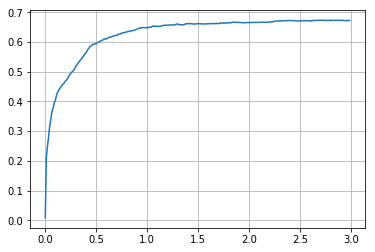

In [44]:
plt.plot(th_list, scores)
plt.grid()

In [45]:
diff_scores5 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["std_avg"] = diff_scores5

2782: 0.2872 [0.044]
7843: 0.9667 [0.000]
10534: 0.6278 [-0.058]
11254: 0.8750 [-0.008]
18003: 0.6611 [0.058]
20152: 0.8833 [-0.058]
21767: 0.3556 [0.050]
26709: 0.5167 [-0.011]
26746: 0.6639 [0.025]
28933: 0.4583 [0.046]
31928: 0.8917 [-0.092]
42907: 0.6250 [-0.092]
44957: 0.7361 [-0.003]
50878: 0.9083 [0.067]
51010: 0.2333 [-0.228]
54955: 0.8333 [-0.008]
57610: 0.9194 [0.014]


## PostProcess v4 -> Simple Avg
それぞれの鳥の最短距離が近いほど値が大きくなるweightを作成して、oof * weightを計算

In [46]:
def post_process_v4(preds, df):
    site_names = list(const.POS_DICT.keys())
    
    distance_array = np.load("../data/processed/valid_distance_array_from_min_position.npy")
    weight_array1 = np.where(distance_array <= 1, 2, 0)
    weight_array2 = np.where(distance_array <= 3, 1, 0)
    weight_array3 = np.where(distance_array <= 5, 0.5, 0)
    weight_array = weight_array1 + weight_array2 + weight_array3
    
    post_preds = np.zeros_like(preds)
    for idx in df.index:
        site = df.loc[idx, "site"]
        site_idx = site_names.index(site)
        
        post_preds[idx, :] = preds[idx, :] * weight_array[site_idx, :]
    
    return post_preds

In [47]:
post_oof112 = post_process_v4(oof112, valid_df)
post_oof114 = post_process_v4(oof114, valid_df)
post_oof115 = post_process_v4(oof115, valid_df)
post_oof116 = post_process_v4(oof116, valid_df)
post_oof117 = post_process_v4(oof117, valid_df)
post_oof118 = post_process_v4(oof118, valid_df)
post_oof121 = post_process_v4(oof121, valid_df)
post_oof129 = post_process_v4(oof129, valid_df)
post_oof131 = post_process_v4(oof131, valid_df)

concat_oof = np.concatenate([
#     post_oof112[np.newaxis, :, :],
#     post_oof114[np.newaxis, :, :],
    post_oof115[np.newaxis, :, :],
    post_oof116[np.newaxis, :, :],
    post_oof117[np.newaxis, :, :],
    post_oof118[np.newaxis, :, :],
    post_oof129[np.newaxis, :, :],
    post_oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [48]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(200):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [49]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7152 (th=0.79)

best score: 0.6877 (th=0.66)


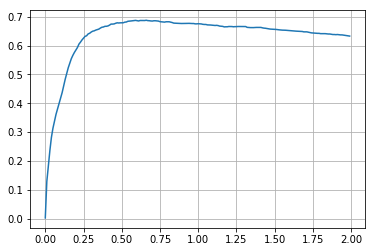

In [50]:
plt.plot(th_list, scores)
plt.grid()

In [51]:
diff_scores6 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["distance_avg"] = diff_scores6

2782: 0.3219 [0.079]
7843: 0.9750 [0.008]
10534: 0.6583 [-0.028]
11254: 0.8639 [-0.019]
18003: 0.6444 [0.042]
20152: 0.9333 [-0.008]
21767: 0.3972 [0.092]
26709: 0.5417 [0.014]
26746: 0.7000 [0.061]
28933: 0.4861 [0.074]
31928: 0.9917 [0.008]
42907: 0.6250 [-0.092]
44957: 0.7778 [0.039]
50878: 0.9333 [0.092]
51010: 0.2333 [-0.228]
54955: 0.8333 [-0.008]
57610: 0.7750 [-0.131]


## PostProcess v4 -> Simple Avg + nocall classification
それぞれの鳥の最短距離が近いほど値が大きくなるweightを作成して、oof * weightを計算

In [52]:
def post_process_v4(preds, df):
    site_names = list(const.POS_DICT.keys())
    
    distance_array = np.load("../data/processed/valid_distance_array_from_min_position.npy")
    weight_array1 = np.where(distance_array <= 1, 2, 0)
    weight_array2 = np.where(distance_array <= 3, 1, 0)
    weight_array3 = np.where(distance_array <= 5, 0.5, 0)
    weight_array = weight_array1 + weight_array2 + weight_array3
    
    post_preds = np.zeros_like(preds)
    for idx in df.index:
        site = df.loc[idx, "site"]
        site_idx = site_names.index(site)
        
        post_preds[idx, :] = preds[idx, :] * weight_array[site_idx, :]
    
    return post_preds

In [53]:
post_oof112 = post_process_v4(oof112, valid_df)
post_oof114 = post_process_v4(oof114, valid_df)
post_oof115 = post_process_v4(oof115, valid_df)
post_oof116 = post_process_v4(oof116, valid_df)
post_oof117 = post_process_v4(oof117, valid_df)
post_oof118 = post_process_v4(oof118, valid_df)
post_oof121 = post_process_v4(oof121, valid_df)
post_oof129 = post_process_v4(oof129, valid_df)
post_oof131 = post_process_v4(oof131, valid_df)

concat_oof = np.concatenate([
#     post_oof112[np.newaxis, :, :],
#     post_oof114[np.newaxis, :, :],
    post_oof115[np.newaxis, :, :],
    post_oof116[np.newaxis, :, :],
    post_oof117[np.newaxis, :, :],
    post_oof118[np.newaxis, :, :],
    post_oof129[np.newaxis, :, :],
    post_oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [54]:
for idx in range(len(oof)):
    nocall_p = 1 - oof99[idx]
    if nocall_p <= 0.05:
        col_idx = np.argsort(oof[idx, :])[-1:]
        oof[idx, col_idx] *= 3

In [55]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(300):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [56]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7399 (th=0.95)

best score: 0.6899 (th=1.97)


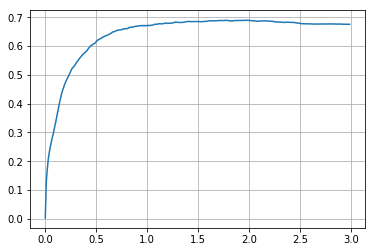

In [57]:
plt.plot(th_list, scores)
plt.grid()

In [58]:
diff_scores7 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["distance_avg_nc"] = diff_scores7

2782: 0.3219 [0.079]
7843: 0.9750 [0.008]
10534: 0.6528 [-0.033]
11254: 0.8583 [-0.025]
18003: 0.6444 [0.042]
20152: 0.9667 [0.025]
21767: 0.4000 [0.094]
26709: 0.5583 [0.031]
26746: 0.6944 [0.056]
28933: 0.4861 [0.074]
31928: 0.9917 [0.008]
42907: 0.6250 [-0.092]
44957: 0.7778 [0.039]
50878: 0.9333 [0.092]
51010: 0.2333 [-0.228]
54955: 0.8333 [-0.008]
57610: 0.7750 [-0.131]


## PostProcess v2 + v4 -> Simple Avg
それぞれの鳥の最短距離が近いほど値が大きくなるweightを作成して、oof * weightを計算

In [59]:
c=1.0
q=0.99
w=1.0

post_oof112 = post_process_v2(oof112, valid_df)
post_oof112 = post_process_v2(post_oof112, valid_df, c, q, w)

post_oof114 = post_process_v2(oof114, valid_df)
post_oof114 = post_process_v2(post_oof114, valid_df, c, q, w)

post_oof115 = post_process_v2(oof115, valid_df)
post_oof115 = post_process_v2(post_oof115, valid_df, c, q, w)

post_oof116 = post_process_v2(oof116, valid_df)
post_oof116 = post_process_v2(post_oof116, valid_df, c, q, w)

post_oof117 = post_process_v2(oof117, valid_df)
post_oof117 = post_process_v2(post_oof117, valid_df, c, q, w)

post_oof118 = post_process_v2(oof118, valid_df)
post_oof118 = post_process_v2(post_oof118, valid_df, c, q, w)

post_oof121 = post_process_v2(oof121, valid_df)
post_oof121 = post_process_v2(post_oof121, valid_df, c, q, w)

post_oof129 = post_process_v2(oof129, valid_df)
post_oof129 = post_process_v2(post_oof129, valid_df, c, q, w)

post_oof131 = post_process_v2(oof131, valid_df)
post_oof131 = post_process_v2(post_oof131, valid_df, c, q, w)

post_oof132 = post_process_v2(oof132, valid_df)
post_oof132 = post_process_v2(post_oof132, valid_df, c, q, w)


concat_oof = np.concatenate([
    post_oof112[np.newaxis, :, :],
    post_oof114[np.newaxis, :, :],
    post_oof115[np.newaxis, :, :],
    post_oof116[np.newaxis, :, :],
    post_oof117[np.newaxis, :, :],
    post_oof118[np.newaxis, :, :],
    post_oof129[np.newaxis, :, :],
    post_oof131[np.newaxis, :, :],
    post_oof132[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [60]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(200):
    th = i / 100.0

    oof_labels = extract_label(oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [61]:
print(f"best score: {best_score:.4f} (th={best_th})")   #  0.6930 (th=0.38)

best score: 0.7042 (th=0.34)


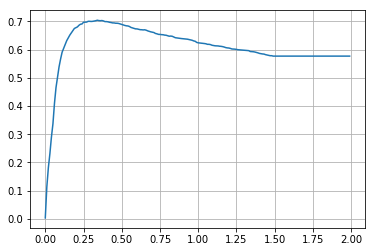

In [62]:
plt.plot(th_list, scores)
plt.grid()

In [63]:
diff_scores8 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["distance_cqw_avg"] = diff_scores8

2782: 0.3206 [0.078]
7843: 0.9667 [0.000]
10534: 0.6694 [-0.017]
11254: 0.9000 [0.017]
18003: 0.6611 [0.058]
20152: 0.9083 [-0.033]
21767: 0.3417 [0.036]
26709: 0.5194 [-0.008]
26746: 0.6778 [0.039]
28933: 0.4542 [0.042]
31928: 0.9750 [-0.008]
42907: 0.7250 [0.008]
44957: 0.7722 [0.033]
50878: 0.8583 [0.017]
51010: 0.4750 [0.014]
54955: 0.8333 [-0.008]
57610: 0.9139 [0.008]


## 前後のlabelがfist_labelと一致していたら...

In [64]:
def intersect(df, col1, col2):
    intersect_list = []
    for idx in df.index.values:
        col1_array = df.loc[idx, col1].split(" ")
        col2_array = df.loc[idx, col2].split(" ")
        intersect = np.intersect1d(col1_array, col2_array)
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def shift(df, freq):
    shift_array = np.array([None] * len(df))

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_array = audio_df["pred_labels"].shift(freq).values
        
        if freq > 0:
            audio_shift_array[:freq] = "None"
        elif freq < 0:
            audio_shift_array[freq:] = "None"
            
        shift_array[idxs] = audio_shift_array

    return shift_array


def arrange_label(label_array):
    arranged_label_array = label_array.copy()
    for idx, label in enumerate(label_array):
        label_list = label.split(" ")
        if "nocall" in label_list and len(label_list) >= 2:
            label_list.remove("nocall")
        
        arranged_label_array[idx] = " ".join(set(label_list))
        
    return arranged_label_array
    

def post_process_v5(preds, pred_labels, df, window_size=1):
    df_  = df.copy()
    
    df_["pred_labels"] = pred_labels
    df_["first_label"] = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds)[:, -1]]
    
    for i in range(window_size):
        df_[f"pre_pred_labels{i}"] = shift(df_, freq=(i + 1))
        df_[f"post_pred_labels{i}"] = shift(df_, freq=-(i + 1))
    
        df_[f"pre_intersect{i}"] = intersect(df_, "first_label", f"pre_pred_labels{i}")
        df_[f"post_intersect{i}"] = intersect(df_, "first_label", f"post_pred_labels{i}")
    
    concat_labels = df_["pred_labels"]
    for col in df_.columns:
        if "pre_intersect" in col or "post_intersect" in col:
            concat_labels += df_[col].apply(lambda x: f" {x}" if len(x) > 0 else "")
            
    df_["concat_labels"] = concat_labels
    
    post_labels = arrange_label(df_["concat_labels"])
    
    return post_labels

In [65]:
valid_df2 = valid_df.copy()

concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
    oof132[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [66]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v5(oof, oof_labels, valid_df2, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [67]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7218 (th=0.27)

best score: 0.7218 (th=0.26)


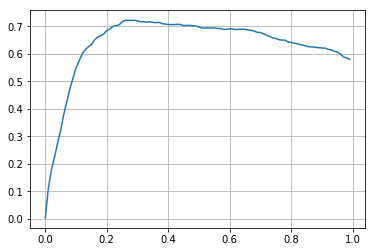

In [68]:
plt.plot(th_list, scores)
plt.grid()

In [69]:
diff_scores9 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["firstlabel_replace"] = diff_scores9

2782: 0.3781 [0.135]
7843: 0.9667 [0.000]
10534: 0.6444 [-0.042]
11254: 0.8694 [-0.014]
18003: 0.7417 [0.139]
20152: 0.8750 [-0.067]
21767: 0.4083 [0.103]
26709: 0.5139 [-0.014]
26746: 0.6944 [0.056]
28933: 0.5236 [0.111]
31928: 0.9917 [0.008]
42907: 0.8417 [0.125]
44957: 0.7750 [0.036]
50878: 0.7583 [-0.083]
51010: 0.5250 [0.064]
54955: 0.8583 [0.017]
57610: 0.9056 [0.000]


## PostProcessV6

- oof_labels = "nocall" & birdcall_p >= 0.99だったら、first_labelを採用

In [70]:
def post_process_v6(preds, pred_labels, birdcall_preds, df):
    first_label = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds, axis=1)[:, -1]]

    processed_pred_labels = []
    for idx, labels in enumerate(pred_labels):
        if labels == "nocall" and birdcall_preds[idx] >= 0.99 and np.max(preds[idx, :]) >= 0.1:
            processed_pred_labels.append(first_label[idx])
        else:
            processed_pred_labels.append(labels)
    
    return processed_pred_labels

In [71]:
concat_oof = np.concatenate([
#     oof112[np.newaxis, :, :],
#     oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [72]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v6(oof, oof_labels, oof99, valid_df)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [73]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7218 (th=0.27)

best score: 0.6484 (th=0.38)


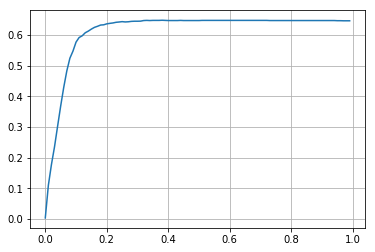

In [74]:
plt.plot(th_list, scores)
plt.grid()

In [75]:
diff_scores10 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["nocall_birdcall_replace"] = diff_scores10

2782: 0.2006 [-0.042]
7843: 0.9667 [0.000]
10534: 0.6667 [-0.019]
11254: 0.9000 [0.017]
18003: 0.5528 [-0.050]
20152: 0.9500 [0.008]
21767: 0.2833 [-0.022]
26709: 0.5306 [0.003]
26746: 0.6556 [0.017]
28933: 0.3944 [-0.018]
31928: 1.0000 [0.017]
42907: 0.7000 [-0.017]
44957: 0.7222 [-0.017]
50878: 0.8750 [0.033]
51010: 0.4528 [-0.008]
54955: 0.8500 [0.008]
57610: 0.9083 [0.003]


## PostProcessV7

- audio_id全体のbirdcall_predsの平均値が0.5以上だったら、PostProcessV5

In [76]:
def intersect(df, col1, col2):
    intersect_list = []
    for idx in df.index.values:
        col1_array = df.loc[idx, col1].split(" ")
        col2_array = df.loc[idx, col2].split(" ")
        intersect = np.intersect1d(col1_array, col2_array)
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def shift(df, freq):
    shift_array = np.array([None] * len(df))

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_array = audio_df["pred_labels"].shift(freq).values
        
        if freq > 0:
            audio_shift_array[:freq] = "None"
        elif freq < 0:
            audio_shift_array[freq:] = "None"
            
        shift_array[idxs] = audio_shift_array

    return shift_array


def arrange_label(label_array):
    arranged_label_array = label_array.copy()
    for idx, label in enumerate(label_array):
        label_list = label.split(" ")
        if "nocall" in label_list and len(label_list) >= 2:
            label_list.remove("nocall")
        
        arranged_label_array[idx] = " ".join(set(label_list))
        
    return arranged_label_array
    

def post_process_v7(preds, pred_labels, birdcall_preds, df, window_size=1):
    df_  = df.copy()
    
    df_["pred_labels"] = pred_labels
    df_["first_label"] = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds)[:, -1]]
    df_["birdcall_preds"] = birdcall_preds
    df_["sum_birdcall_preds"] = df_.groupby("audio_id")["birdcall_preds"].transform("mean")
    
    for i in range(window_size):
        df_[f"pre_pred_labels{i}"] = shift(df_, freq=(i + 1))
        df_[f"post_pred_labels{i}"] = shift(df_, freq=-(i + 1))
    
        df_[f"pre_intersect{i}"] = intersect(df_, "first_label", f"pre_pred_labels{i}")
        df_[f"post_intersect{i}"] = intersect(df_, "first_label", f"post_pred_labels{i}")
    
    concat_labels = df_["pred_labels"]
    for col in df_.columns:
        if "pre_intersect" in col or "post_intersect" in col:
            concat_labels += df_[col].apply(lambda x: f" {x}" if len(x) > 0 else "")
            
    df_["concat_labels"] = arrange_label(concat_labels)
    
    post_pred_labels = []
    for idx in df_.index:
        audio_birdcall_preds = df_.loc[idx, "sum_birdcall_preds"]
        if audio_birdcall_preds >= 0.5:
            post_label = df_.loc[idx, "concat_labels"]
        else:
            post_label = df_.loc[idx, "pred_labels"]
            
        post_pred_labels.append(post_label)
    
    return post_pred_labels

In [77]:
concat_oof = np.concatenate([
#     oof112[np.newaxis, :, :],
#     oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [78]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v7(oof, oof_labels, oof99, valid_df, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [79]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7218 (th=0.27)

best score: 0.7102 (th=0.27)


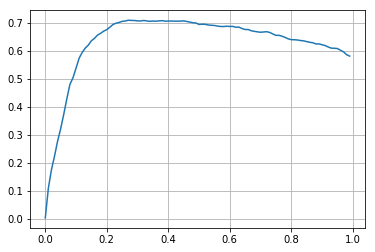

In [80]:
plt.plot(th_list, scores)
plt.grid()

In [81]:
diff_scores11 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["birdcall_preds0.5_and_v5"] = diff_scores11

2782: 0.2622 [0.019]
7843: 0.9667 [0.000]
10534: 0.6278 [-0.058]
11254: 0.8917 [0.008]
18003: 0.6028 [0.000]
20152: 0.9000 [-0.042]
21767: 0.3444 [0.039]
26709: 0.5417 [0.014]
26746: 0.6917 [0.053]
28933: 0.4389 [0.026]
31928: 0.9833 [0.000]
42907: 0.7250 [0.008]
44957: 0.7389 [0.000]
50878: 0.8250 [-0.017]
51010: 0.5028 [0.042]
54955: 0.8500 [0.008]
57610: 0.8972 [-0.008]


## PostProcessV8

- PostProcessV5の修正版

In [80]:
def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v8(preds, pred_labels, df, window_size=1):
    confident_labels = [const.INV_BIRD_CODE[bc] for bc in np.argsort(preds)[:, -1]]

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(confident_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list

In [81]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
    oof132[np.newaxis, :, :],
#     oof133[np.newaxis, :, :],
#     oof134[np.newaxis, :, :],
    oof135[np.newaxis, :, :],
    oof136[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [82]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_labels = post_process_v8(oof, oof_labels, valid_df, window_size=3)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_labels

    th_list.append(th)
    scores.append(score)

In [83]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7218 (th=0.26)

best score: 0.7226 (th=0.26)


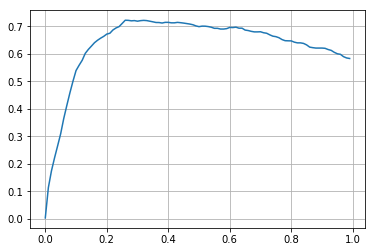

In [84]:
plt.plot(th_list, scores)
plt.grid()

In [85]:
diff_scores12 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["modified_firstlabel_replace"] = diff_scores12

2782: 0.4017 [0.159]
7843: 0.9833 [0.017]
10534: 0.6333 [-0.053]
11254: 0.8694 [-0.014]
18003: 0.7250 [0.122]
20152: 0.8417 [-0.100]
21767: 0.4167 [0.111]
26709: 0.5306 [0.003]
26746: 0.6861 [0.047]
28933: 0.5458 [0.133]
31928: 0.9917 [0.008]
42907: 0.8417 [0.125]
44957: 0.7694 [0.031]
50878: 0.7417 [-0.100]
51010: 0.5500 [0.089]
54955: 0.8667 [0.025]
57610: 0.8889 [-0.017]


In [86]:
a = valid_df.copy()
a["preds"] = best_final_labels
a.iloc[:240]["preds"].value_counts()

nocall             127
rucwar              76
obnthr1              6
incdov               6
yebfly               4
wbwwre1              4
rubwre1              3
grasal1              3
brnjay               2
belkin1              2
bucmot2              2
laufal1              1
sthwoo1              1
baywre1              1
strfly1              1
rubwre1 wbwwre1      1
Name: preds, dtype: int64

## Avg -> V2 -> V5

In [37]:
def post_process_v2_plus(preds, df, c=2, q=0.99, w=1.5):
    post_preds = preds.copy()
    
    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        site = audio_df.loc[idxs[0], "site"]
        
        audio_preds = preds[idxs, :]
        audio_preds_mean = np.mean(audio_preds, axis=0)
        audio_preds_mean_ = audio_preds_mean / audio_preds_mean.max()
        quantile = np.quantile(audio_preds_mean_, q)

        for bc in np.argsort(audio_preds_mean_)[::-1]:
            v = audio_preds_mean_[bc]
            if v >= (quantile * c):
                for idx in idxs:
                    if np.argmax(post_preds[idx, :]) == bc:
                        post_preds[idx, bc] *= w
            else:
                break

    return post_preds

In [38]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
    oof132[np.newaxis, :, :],
#     oof133[np.newaxis, :, :],
#     oof134[np.newaxis, :, :],
    oof135[np.newaxis, :, :],
], axis=0)


oof = np.mean(concat_oof, axis=0)[use_idx, :]

c=2.0
q=0.99
w=5.0

post_oof = post_process_v2_plus(oof, valid_df, c, q, w)

In [39]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(300)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    post_labels = post_process_v8(post_oof, oof_labels, valid_df, window_size=2)

    score = row_wise_micro_averaged_f1_score(val_y_labels, post_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [40]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7506 (th=0.27)

best score: 0.7220 (th=1.38)


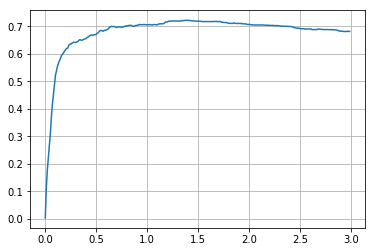

In [41]:
plt.plot(th_list, scores)
plt.grid()

In [42]:
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.2719 [0.029]
7843: 0.9667 [0.000]
10534: 0.6194 [-0.067]
11254: 0.8750 [-0.008]
18003: 0.6278 [0.025]
20152: 0.9417 [0.000]
21767: 0.3083 [0.003]
26709: 0.5083 [-0.019]
26746: 0.6861 [0.047]
28933: 0.4361 [0.024]
31928: 1.0000 [0.017]
42907: 0.7250 [0.008]
44957: 0.7556 [0.017]
50878: 0.9583 [0.117]
51010: 0.4222 [-0.039]
54955: 0.8333 [-0.008]
57610: 0.9278 [0.022]


## PostProcessV9
- https://www.kaggle.com/cdeotte/rainforest-post-process-lb-0-970
- 全然うまくいかない......というかよく分かっていない

In [95]:
def scale(probs, factor):
    probs = probs.copy()
    idx = np.where(probs!=1)[0]
    odds = factor * probs[idx] / (1 - probs[idx])
    probs[idx] =  odds / (1 + odds)
    return probs


def post_process_v9(preds):
    post_preds = preds.copy()

    post_preds -= post_preds.min(0, keepdims=True)
    post_preds /= post_preds.max(0, keepdims=True)
    d2 = np.mean(post_preds, axis=0)

    for k in range(397):
        s = (d2[k] / (1 - d2[k])) / 2.0
        post_preds[:, k] = scale(post_preds[:, k], s)

    return post_preds

In [96]:
concat_oof = np.concatenate([
#     oof112[np.newaxis, :, :],
#     oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]
post_oof = post_process_v9(oof)

In [97]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)
    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [98]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7506 (th=0.27)

best score: 0.5234 (th=0.87)


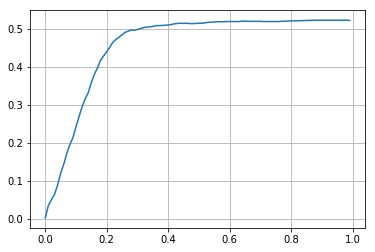

In [99]:
plt.plot(th_list, scores)
plt.grid()

In [100]:
diff_scores13 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores13

2782: 0.0194 [-0.223]
7843: 0.9500 [-0.017]
10534: 0.4750 [-0.211]
11254: 0.7167 [-0.167]
18003: 0.1250 [-0.478]
20152: 0.9167 [-0.025]
21767: 0.1833 [-0.122]
26709: 0.4667 [-0.061]
26746: 0.5333 [-0.106]
28933: 0.1597 [-0.253]
31928: 0.9417 [-0.042]
42907: 0.5306 [-0.186]
44957: 0.3667 [-0.372]
50878: 0.7667 [-0.075]
51010: 0.2417 [-0.219]
54955: 0.7917 [-0.050]
57610: 0.7139 [-0.192]


## PostProcessV10
- PPv8の修正版？

In [87]:
def shift(df, pred_labels, freq):
    shift_labels = [None] * len(df)

    gp = df.groupby("audio_id")
    for audio_id, audio_df in gp:
        idxs = audio_df.index.values
        audio_shift_labels = np.roll(pred_labels[idxs[0]: idxs[-1] + 1], freq)
        
        if freq > 0:
            audio_shift_labels[:freq] = "None"
        elif freq < 0:
            audio_shift_labels[freq:] = "None"
            
        shift_labels[idxs[0]: idxs[-1] + 1] = audio_shift_labels

    return shift_labels


def intersect(labels_list1, labels_list2):
    intersect_list = []
    for idx in range(len(labels_list1)):
        lables1 = labels_list1[idx].split(" ")
        lables2 = labels_list2[idx].split(" ")
        
        intersect = np.intersect1d(lables1, lables2)
        if len(intersect) == 0:
            intersect = ["nocall"]
        intersect_list.append(" ".join(list(intersect)))
        
    return intersect_list


def add_label(labels_list1, labels_list2):
    added_labels_list = []
    for labels1, labels2 in zip(labels_list1, labels_list2):

        if labels1 == "nocall":
            if labels2 == "nocall":
                added_labels_list.append("nocall")
            else:
                added_labels_list.append(labels2)
        
        else:
            if labels2 == "nocall":
                added_labels_list.append(labels1)
            else:
                added_labels = list(set((labels1 + " " + labels2).split(" ")))
                added_labels_list.append(" ".join(added_labels))
    
    return added_labels_list


def post_process_v10(preds, pred_labels, df, window_size=1, c=2.0):
    first_labels = []
    for idx in df.index:
        row_prob = preds[idx, :]
        second_prob = np.sort(row_prob)[-2]

        first_label_bc = np.argmax(row_prob)
        v = row_prob[first_label_bc]
        if v >= (second_prob * c):
            first_labels.append(const.INV_BIRD_CODE[first_label_bc])
        else:
            first_labels.append("nocall")

    final_labels_list = pred_labels.copy()
    for w in range(window_size):
        for freq in [w + 1, -(w + 1)]:
            shift_labels = shift(df, pred_labels, freq)
            shift_intersect_labels = intersect(first_labels, shift_labels)
            final_labels_list = add_label(final_labels_list, shift_intersect_labels)
        
    return final_labels_list

In [103]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
    oof132[np.newaxis, :, :],
#     oof133[np.newaxis, :, :],
#     oof134[np.newaxis, :, :],
    oof135[np.newaxis, :, :],
    oof136[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]

In [104]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_oof_labels = post_process_v10(oof, oof_labels, valid_df, window_size=2, c=2)
    score = row_wise_micro_averaged_f1_score(val_y_labels, post_oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_oof_labels

    th_list.append(th)
    scores.append(score)

In [105]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7140 (th=0.29)

best score: 0.7113 (th=0.44)


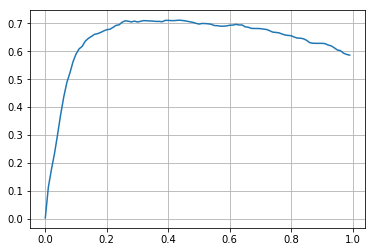

In [106]:
plt.plot(th_list, scores)
plt.grid()

In [107]:
diff_scores14 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["cqw_and_modified_firstlabel_replace"] = diff_scores14

2782: 0.2872 [0.044]
7843: 0.9667 [0.000]
10534: 0.6139 [-0.072]
11254: 0.8667 [-0.017]
18003: 0.6611 [0.058]
20152: 0.9083 [-0.033]
21767: 0.3500 [0.044]
26709: 0.5528 [0.025]
26746: 0.6861 [0.047]
28933: 0.4903 [0.078]
31928: 1.0000 [0.017]
42907: 0.8167 [0.100]
44957: 0.7889 [0.050]
50878: 0.8417 [0.000]
51010: 0.5278 [0.067]
54955: 0.8333 [-0.008]
57610: 0.9000 [-0.006]


## PostProcessV11

In [107]:
def post_process_v11(preds, birdcall_preds, th=0.3, w=0.5):
    post_preds = preds.copy()
    for idx in range(len(preds)):
        bc_prob = birdcall_preds[idx]
        if bc_prob <= th:
            post_preds[idx, :] = preds[idx, :] * w
    
    return post_preds

In [108]:
concat_oof = np.concatenate([
#     oof112[np.newaxis, :, :],
#     oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
    oof129[np.newaxis, :, :],
    oof131[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]
bc_oof = oof99.copy()
post_oof = post_process_v11(oof, bc_oof, th=0.5, w=0.1)

In [109]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in range(100):
    th = i / 100.0

    oof_labels = extract_label(post_oof, th)

    score = row_wise_micro_averaged_f1_score(val_y_labels, oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = oof_labels

    th_list.append(th)
    scores.append(score)

In [110]:
print(f"best score: {best_score:.4f} (th={best_th})")   # best score:0.7408 (th=0.33)

best score: 0.6970 (th=0.27)


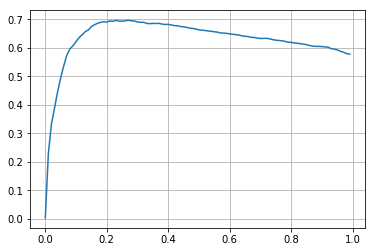

In [111]:
plt.plot(th_list, scores)
plt.grid()

In [112]:
diff_scores1 = get_audio_score(best_final_labels, valid_df, score_dict)
all_diff_scores["avg_nc"] = diff_scores1

2782: 0.2622 [0.019]
7843: 0.9667 [0.000]
10534: 0.6278 [-0.058]
11254: 0.8917 [0.008]
18003: 0.6028 [0.000]
20152: 0.9500 [0.008]
21767: 0.3444 [0.039]
26709: 0.5500 [0.022]
26746: 0.6917 [0.053]
28933: 0.4306 [0.018]
31928: 0.9833 [0.000]
42907: 0.7250 [0.008]
44957: 0.7389 [0.000]
50878: 0.8250 [-0.017]
51010: 0.5028 [0.042]
54955: 0.8583 [0.017]
57610: 0.8972 [-0.008]


## PostProcessV12
- weighted avg -> V10

In [72]:
def opt_ensemble_weight(y_true, oof_list, metric):
    def objective(trial):
        p_list = [0 for i in range(len(oof_list))]
        for i in range(len(oof_list) - 1):
            p_list[i] = trial.suggest_discrete_uniform(
                f"p{i}", 0.0, 1.0 - sum(p_list), 0.01
            )
        p_list[-1] = round(1 - sum(p_list[:-1]), 2)

        y_pred = np.zeros((len(y_true), 397))
        for i in range(len(oof_list)):
            y_pred += oof_list[i][use_idx, :] * p_list[i]
            
        y_pred_labels = extract_label(y_pred, th=0.3)

        return 1 - metric(y_true, y_pred_labels)

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, timeout=120)
    best_params = list(study.best_params.values())
    best_weight = best_params + [round(1 - sum(best_params), 2)]

    return best_weight

In [73]:
oof_list = [
    oof112,
    oof114,
    oof115,
    oof116,
    oof117,
    oof118,

    oof129,
    oof131,
    oof132,
    
    oof135,
    oof136,
]

best_weight = opt_ensemble_weight(val_y_labels, oof_list, row_wise_micro_averaged_f1_score)

[I 2021-05-25 12:28:19,631] Finished a trial resulted in value: 0.32277777777778016. Current best value is 0.32277777777778016 with parameters: {'p0': 0.35000000000000003, 'p1': 0.4, 'p2': 0.18, 'p3': 0.02, 'p4': 0.0, 'p5': 0.03, 'p6': 0.01, 'p7': 0.01, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:19,683] Finished a trial resulted in value: 0.3507516339869303. Current best value is 0.32277777777778016 with parameters: {'p0': 0.35000000000000003, 'p1': 0.4, 'p2': 0.18, 'p3': 0.02, 'p4': 0.0, 'p5': 0.03, 'p6': 0.01, 'p7': 0.01, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:19,725] Finished a trial resulted in value: 0.3409477124183029. Current best value is 0.32277777777778016 with parameters: {'p0': 0.35000000000000003, 'p1': 0.4, 'p2': 0.18, 'p3': 0.02, 'p4': 0.0, 'p5': 0.03, 'p6': 0.01, 'p7': 0.01, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:19,767] Finished a trial resulted in value: 0.3337091503267997. Current best value is 0.32277777777778016 with parameters: {'p0': 0.3500000000000

[I 2021-05-25 12:28:21,502] Finished a trial resulted in value: 0.3487091503267996. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.0, 'p6': -0.0, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:21,584] Finished a trial resulted in value: 0.33563725490196306. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.0, 'p6': -0.0, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:21,665] Finished a trial resulted in value: 0.32735294117647296. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.0, 'p6': -0.0, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:21,741] Finished a trial resulted in value: 0.35178104575163627. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.

[I 2021-05-25 12:28:24,287] Finished a trial resulted in value: 0.3347549019607866. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.0, 'p6': -0.0, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:24,387] Finished a trial resulted in value: 0.33245098039215915. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.0, 'p6': -0.0, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:24,486] Finished a trial resulted in value: 0.32212418300653833. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.0, 'p6': -0.0, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:24,589] Finished a trial resulted in value: 0.34111111111111336. Current best value is 0.3217483660130742 with parameters: {'p0': 0.43, 'p1': 0.19, 'p2': 0.26, 'p3': 0.12, 'p4': -0.0, 'p5': 0.

[I 2021-05-25 12:28:27,670] Finished a trial resulted in value: 0.32326797385621153. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:27,799] Finished a trial resulted in value: 0.33416666666666894. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:27,934] Finished a trial resulted in value: 0.33245098039215915. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:28,065] Finished a trial resulted in value: 0.35488562091503495. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 

[I 2021-05-25 12:28:31,801] Finished a trial resulted in value: 0.3294281045751657. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:31,950] Finished a trial resulted in value: 0.33988562091503494. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:32,094] Finished a trial resulted in value: 0.33416666666666894. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:32,240] Finished a trial resulted in value: 0.32130718954248605. Current best value is 0.31812091503268214 with parameters: {'p0': 0.37, 'p1': 0.29, 'p2': 0.23, 'p3': 0.11, 'p4': -0.0, '

[I 2021-05-25 12:28:36,543] Finished a trial resulted in value: 0.3180392156862769. Current best value is 0.3180392156862769 with parameters: {'p0': 0.35000000000000003, 'p1': 0.27, 'p2': 0.3, 'p3': 0.08, 'p4': 0.0, 'p5': -0.0, 'p6': -0.0, 'p7': -0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:36,712] Finished a trial resulted in value: 0.31758169934640756. Current best value is 0.31758169934640756 with parameters: {'p0': 0.36, 'p1': 0.27, 'p2': 0.31, 'p3': 0.03, 'p4': 0.01, 'p5': 0.02, 'p6': 0.0, 'p7': 0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:36,882] Finished a trial resulted in value: 0.31921568627451213. Current best value is 0.31758169934640756 with parameters: {'p0': 0.36, 'p1': 0.27, 'p2': 0.31, 'p3': 0.03, 'p4': 0.01, 'p5': 0.02, 'p6': 0.0, 'p7': 0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:37,057] Finished a trial resulted in value: 0.32379084967320493. Current best value is 0.31758169934640756 with parameters: {'p0': 0.36, 'p1': 0.27, 'p2': 0.31, 'p3': 0.03, 'p4'

[I 2021-05-25 12:28:42,075] Finished a trial resulted in value: 0.3242483660130743. Current best value is 0.31758169934640756 with parameters: {'p0': 0.36, 'p1': 0.27, 'p2': 0.31, 'p3': 0.03, 'p4': 0.01, 'p5': 0.02, 'p6': 0.0, 'p7': 0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:42,290] Finished a trial resulted in value: 0.3362908496732049. Current best value is 0.31758169934640756 with parameters: {'p0': 0.36, 'p1': 0.27, 'p2': 0.31, 'p3': 0.03, 'p4': 0.01, 'p5': 0.02, 'p6': 0.0, 'p7': 0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:42,486] Finished a trial resulted in value: 0.3151797385620939. Current best value is 0.3151797385620939 with parameters: {'p0': 0.26, 'p1': 0.31, 'p2': 0.24, 'p3': 0.14, 'p4': 0.04, 'p5': -0.0, 'p6': 0.01, 'p7': -0.0, 'p8': 0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:42,683] Finished a trial resulted in value: 0.325604575163401. Current best value is 0.3151797385620939 with parameters: {'p0': 0.26, 'p1': 0.31, 'p2': 0.24, 'p3': 0.14, 'p4': 0.04, 'p5': -0.0,

[I 2021-05-25 12:28:51,947] Finished a trial resulted in value: 0.3182843137254926. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:52,168] Finished a trial resulted in value: 0.319509803921571. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:52,397] Finished a trial resulted in value: 0.3366176470588258. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:52,633] Finished a trial resulted in value: 0.33473856209150554. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0

[I 2021-05-25 12:28:58,907] Finished a trial resulted in value: 0.3243300653594795. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:59,150] Finished a trial resulted in value: 0.3249019607843161. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:59,388] Finished a trial resulted in value: 0.3278431372549043. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:28:59,628] Finished a trial resulted in value: 0.32444444444444676. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -

[I 2021-05-25 12:29:06,531] Finished a trial resulted in value: 0.31839869281045985. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:06,792] Finished a trial resulted in value: 0.31692810457516574. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:07,051] Finished a trial resulted in value: 0.32101307189542716. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:07,315] Finished a trial resulted in value: 0.3623856209150349. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5':

[I 2021-05-25 12:29:14,721] Finished a trial resulted in value: 0.3211437908496756. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:15,005] Finished a trial resulted in value: 0.3255065359477147. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:15,294] Finished a trial resulted in value: 0.31872549019608076. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:15,581] Finished a trial resulted in value: 0.3252777777777801. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -

[I 2021-05-25 12:29:23,676] Finished a trial resulted in value: 0.32183006535947944. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:23,986] Finished a trial resulted in value: 0.32125816993464285. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:24,296] Finished a trial resulted in value: 0.32454248366013305. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:24,610] Finished a trial resulted in value: 0.3231045751634011. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5':

[I 2021-05-25 12:29:33,399] Finished a trial resulted in value: 0.3260784313725513. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:33,740] Finished a trial resulted in value: 0.3173366013071919. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:34,115] Finished a trial resulted in value: 0.3366176470588258. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:34,457] Finished a trial resulted in value: 0.32307189542483894. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -

[I 2021-05-25 12:29:44,290] Finished a trial resulted in value: 0.31763071895425077. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:44,718] Finished a trial resulted in value: 0.31978758169934873. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:45,147] Finished a trial resulted in value: 0.32307189542483894. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:45,521] Finished a trial resulted in value: 0.33049019607843366. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5'

[I 2021-05-25 12:29:55,727] Finished a trial resulted in value: 0.32200980392157097. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:56,116] Finished a trial resulted in value: 0.32245098039215925. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:56,497] Finished a trial resulted in value: 0.31586601307189777. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:29:56,898] Finished a trial resulted in value: 0.31763071895425077. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5'

[I 2021-05-25 12:30:07,740] Finished a trial resulted in value: 0.3242810457516363. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:30:08,144] Finished a trial resulted in value: 0.3190522875817017. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:30:08,553] Finished a trial resulted in value: 0.31897058823529645. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': -0.0, 'p6': 0.01, 'p7': 0.0, 'p8': -0.0, 'p9': -0.0}.
[I 2021-05-25 12:30:08,960] Finished a trial resulted in value: 0.32264705882353173. Current best value is 0.3137091503267998 with parameters: {'p0': 0.32, 'p1': 0.25, 'p2': 0.19, 'p3': 0.18, 'p4': 0.05, 'p5': 

In [79]:
best_weight

[0.32, 0.25, 0.19, 0.18, 0.05, -0.0, 0.01, 0.0, -0.0, -0.0, 0.0]

In [74]:
oof = np.zeros_like(oof112)
for p, w in zip(oof_list, best_weight):
    oof += p * w
oof = oof[use_idx, :]

In [75]:
th_list = []
scores = []

best_score = 0
besth_th = 0
best_final_labels = None

for i in tqdm(range(100)):
    th = i / 100.0

    oof_labels = extract_label(oof, th)
    post_oof_labels = post_process_v10(oof, oof_labels, valid_df, window_size=2, c=1.5)
    score = row_wise_micro_averaged_f1_score(val_y_labels, post_oof_labels)
    
    if best_score < score:
        best_score  = score
        best_th = th
        best_final_labels = post_oof_labels

    th_list.append(th)
    scores.append(score)

In [76]:
print(f"best score: {best_score:.4f} (th={best_th})")   # 0.7140 (th=0.29)

best score: 0.7026 (th=0.44)


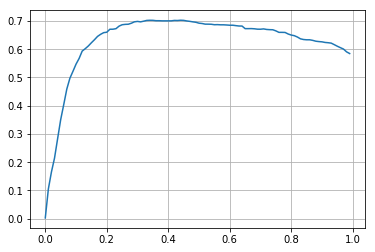

In [77]:
plt.plot(th_list, scores)
plt.grid()

## 閾値研究

In [119]:
def optim_th(y_labels, preds):
    best_score = 0
    besth_th = 0
    best_final_labels = None
    base_score = 0

    for i in range(100):
        th = i / 100.0

        pred_labels = extract_label(preds, th)

        score = row_wise_micro_averaged_f1_score(y_labels, pred_labels)

        if best_score < score:
            best_score  = score
            best_th = th
            best_final_labels = pred_labels
            
        if th == 0.33:
            base_score = score
        
    return best_score, best_th, base_score


def get_info(df):
    site = df["site"].values[0]
    nocall_num = len(df[df["birds"] == "nocall"])
    birdcall_num = len(df[df["birds"] != "nocall"])
    return site, nocall_num, birdcall_num


def get_preds_info(preds):
    mean_row_mean = preds.mean(axis=0).mean()
    mean_row_max = preds.max(axis=0).mean()
    return mean_row_mean, mean_row_max

def get_pred_labels_info(pred_labels):
    pred_nocall_count = 0
    for labels in pred_labels:
        if labels == "nocall":
            pred_nocall_count += 1
    
    return pred_nocall_count

In [120]:
concat_oof = np.concatenate([
    oof112[np.newaxis, :, :],
    oof114[np.newaxis, :, :],
    oof115[np.newaxis, :, :],
    oof116[np.newaxis, :, :],
    oof117[np.newaxis, :, :],
    oof118[np.newaxis, :, :],
], axis=0)

oof = np.mean(concat_oof, axis=0)[use_idx, :]
oof_labels = extract_label(oof, th=0.33)

In [121]:
th_dict = {}

gp = valid_df.groupby("audio_id")
for audio_id, audio_df in gp:
    idx = audio_df.index.values
    score, th, base_score = optim_th(audio_df["birds"].values, oof[idx, :])
    site, nocall_num, birdcall_num = get_info(audio_df)
    mean_row_mean, mean_row_max = get_preds_info(oof[idx, :])
    birdcall_p = oof99[idx, :].mean()
    pred_nocall_count = get_pred_labels_info(oof_labels[idx[0]: idx[-1] + 1])

    th_dict[audio_id] = {
        "site": site,
        "best_th": th,
        "score": score,
        "change_score": score - base_score,
        "nocall_num": nocall_num,
        "birdcall_num": birdcall_num,
        "mean_row_mean": mean_row_mean,
        "mean_row_max": mean_row_max,
        "birdcall_p": birdcall_p,
        "pred_nocall_count": pred_nocall_count,
    }

In [122]:
score_df = pd.DataFrame.from_dict(th_dict, orient="index")
score_df.sort_values(by="best_th")

,site,best_th,score,change_score,nocall_num,birdcall_num,mean_row_mean,mean_row_max,birdcall_p,pred_nocall_count
2782,SSW,0.05,0.464603,0.221825,0,120,0.003073,0.024086,0.993905,77
28933,SSW,0.08,0.544444,0.131944,18,102,0.003111,0.028188,0.956717,77
18003,COR,0.14,0.650000,0.047222,24,96,0.002838,0.028736,0.993982,64
21767,COR,0.14,0.415278,0.109722,22,98,0.002720,0.034606,0.999986,94
7843,SSW,0.17,0.975000,0.008333,116,4,0.003550,0.009434,0.639814,120
44957,COR,0.22,0.738889,0.000000,49,71,0.003172,0.031696,0.994803,65
26746,COR,0.22,0.691667,0.052778,71,49,0.002857,0.024970,0.999573,111
42907,SSW,0.25,0.741667,0.025000,75,45,0.003134,0.023079,0.725713,103
10534,SSW,0.31,0.694444,0.008333,63,57,0.003055,0.036569,0.904794,83
54955,SSW,0.33,0.841667,0.000000,100,20,0.003228,0.015819,0.198811,118


In [123]:
(score_df["score"].values * 120).sum() / 2040

0.7385224089635851

In [124]:
diff_df = pd.DataFrame.from_dict(all_diff_scores)
columns = list(diff_df.columns)

diff_df = pd.concat([
    valid_df[valid_df["birds"] == "nocall"].groupby("audio_id").size(),
    valid_df.groupby("audio_id")["site"].unique(),
    pd.DataFrame.from_dict(score_dict, orient="index", columns=["score"]),
    diff_df,
], axis=1)

diff_df.columns = ["nocall_num", "site", "score"] + columns

diff_df["nocall_num"] = diff_df["nocall_num"].fillna(0)
diff_df["site"] = diff_df["site"].apply(lambda x: x[0])

diff_df.sort_values(by="nocall_num")

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
2782,0.0,SSW,0.242778,0.031944,0.019444,0.058056,0.016944,0.045833,0.044444,0.079167,0.079167,0.077778,0.135278,-0.042222,0.019444,0.126944,0.100556
28933,18.0,SSW,0.412500,0.041667,0.018056,0.062500,0.112500,0.041667,0.045833,0.073611,0.073611,0.041667,0.111111,-0.018056,0.026389,0.106944,0.098611
21767,22.0,COR,0.305556,0.036111,0.038889,0.050000,0.044444,0.077778,0.050000,0.091667,0.094444,0.036111,0.102778,-0.022222,0.038889,0.094444,0.050000
18003,24.0,COR,0.602778,0.041667,0.000000,0.041667,0.022222,0.033333,0.058333,0.041667,0.041667,0.058333,0.138889,-0.050000,0.000000,0.130556,0.097222
51010,28.0,SSW,0.461111,0.036111,0.041667,0.025000,0.004167,-0.005556,-0.227778,-0.227778,-0.227778,0.013889,0.063889,-0.008333,0.041667,0.047222,0.047222
44957,49.0,COR,0.738889,0.000000,0.000000,-0.008333,-0.016667,0.033333,-0.002778,0.038889,0.038889,0.033333,0.036111,-0.016667,0.000000,0.036111,0.008333
26709,62.0,SSW,0.527778,-0.008333,0.022222,0.016667,0.016667,-0.013889,-0.011111,0.013889,0.030556,-0.008333,-0.013889,0.002778,0.013889,-0.019444,0.011111
10534,63.0,SSW,0.686111,0.000000,-0.058333,-0.027778,-0.188889,-0.033333,-0.058333,-0.027778,-0.033333,-0.016667,-0.041667,-0.019444,-0.058333,-0.033333,-0.016667
26746,71.0,COR,0.638889,0.047222,0.052778,0.063889,0.041667,0.047222,0.025000,0.061111,0.055556,0.038889,0.055556,0.016667,0.052778,0.038889,0.038889
42907,75.0,SSW,0.716667,0.016667,0.008333,0.047222,0.025000,-0.033333,-0.091667,-0.091667,-0.091667,0.008333,0.125000,-0.016667,0.008333,0.108333,0.091667


In [125]:
diff_df[diff_df["nocall_num"] >= 100]

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
7843,116.0,SSW,0.966667,0.000000,0.000000,0.008333,0.000000,0.000000,0.000000,0.008333,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11254,105.0,COR,0.883333,-0.002778,0.008333,-0.019444,-0.125000,0.016667,-0.008333,-0.019444,-0.025000,0.016667,-0.013889,0.016667,0.008333,-0.011111,-0.011111
20152,116.0,SSW,0.941667,0.000000,0.008333,-0.091667,-0.016667,-0.050000,-0.058333,-0.008333,0.025000,-0.033333,-0.066667,0.008333,-0.041667,-0.075000,-0.075000
31928,120.0,COR,0.983333,0.008333,0.000000,0.008333,0.016667,-0.008333,-0.091667,0.008333,0.008333,-0.008333,0.008333,0.016667,0.000000,0.008333,0.008333
50878,115.0,COR,0.841667,-0.033333,-0.016667,-0.050000,-0.058333,0.033333,0.066667,0.091667,0.091667,0.016667,-0.083333,0.033333,-0.016667,-0.041667,-0.008333
54955,100.0,SSW,0.841667,0.016667,0.016667,0.008333,-0.016667,-0.008333,-0.008333,-0.008333,-0.008333,-0.008333,0.016667,0.008333,0.008333,0.016667,0.000000


In [126]:
diff_df[diff_df["site"] == "SSW"].sort_values(by="nocall_num")

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
2782,0.0,SSW,0.242778,0.031944,0.019444,0.058056,0.016944,0.045833,0.044444,0.079167,0.079167,0.077778,0.135278,-0.042222,0.019444,0.126944,0.100556
28933,18.0,SSW,0.412500,0.041667,0.018056,0.062500,0.112500,0.041667,0.045833,0.073611,0.073611,0.041667,0.111111,-0.018056,0.026389,0.106944,0.098611
51010,28.0,SSW,0.461111,0.036111,0.041667,0.025000,0.004167,-0.005556,-0.227778,-0.227778,-0.227778,0.013889,0.063889,-0.008333,0.041667,0.047222,0.047222
26709,62.0,SSW,0.527778,-0.008333,0.022222,0.016667,0.016667,-0.013889,-0.011111,0.013889,0.030556,-0.008333,-0.013889,0.002778,0.013889,-0.019444,0.011111
10534,63.0,SSW,0.686111,0.000000,-0.058333,-0.027778,-0.188889,-0.033333,-0.058333,-0.027778,-0.033333,-0.016667,-0.041667,-0.019444,-0.058333,-0.033333,-0.016667
42907,75.0,SSW,0.716667,0.016667,0.008333,0.047222,0.025000,-0.033333,-0.091667,-0.091667,-0.091667,0.008333,0.125000,-0.016667,0.008333,0.108333,0.091667
54955,100.0,SSW,0.841667,0.016667,0.016667,0.008333,-0.016667,-0.008333,-0.008333,-0.008333,-0.008333,-0.008333,0.016667,0.008333,0.008333,0.016667,0.000000
7843,116.0,SSW,0.966667,0.000000,0.000000,0.008333,0.000000,0.000000,0.000000,0.008333,0.008333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
20152,116.0,SSW,0.941667,0.000000,0.008333,-0.091667,-0.016667,-0.050000,-0.058333,-0.008333,0.025000,-0.033333,-0.066667,0.008333,-0.041667,-0.075000,-0.075000


In [127]:
diff_df[diff_df["site"] == "COR"].sort_values(by="nocall_num")

,nocall_num,site,score,avg,avg_nc,voting,avg_postv12,cqw_avg,std_avg,distance_avg,distance_avg_nc,distance_cqw_avg,firstlabel_replace,nocall_birdcall_replace,birdcall_preds0.5_and_v5,modified_firstlabel_replace,cqw_and_modified_firstlabel_replace
21767,22.0,COR,0.305556,0.036111,0.038889,0.050000,0.044444,0.077778,0.050000,0.091667,0.094444,0.036111,0.102778,-0.022222,0.038889,0.094444,0.050000
18003,24.0,COR,0.602778,0.041667,0.000000,0.041667,0.022222,0.033333,0.058333,0.041667,0.041667,0.058333,0.138889,-0.050000,0.000000,0.130556,0.097222
44957,49.0,COR,0.738889,0.000000,0.000000,-0.008333,-0.016667,0.033333,-0.002778,0.038889,0.038889,0.033333,0.036111,-0.016667,0.000000,0.036111,0.008333
26746,71.0,COR,0.638889,0.047222,0.052778,0.063889,0.041667,0.047222,0.025000,0.061111,0.055556,0.038889,0.055556,0.016667,0.052778,0.038889,0.038889
57610,93.0,COR,0.905556,0.000000,-0.008333,-0.016667,-0.077778,0.008333,0.013889,-0.130556,-0.130556,0.008333,0.000000,0.002778,-0.008333,0.000000,0.000000
11254,105.0,COR,0.883333,-0.002778,0.008333,-0.019444,-0.125000,0.016667,-0.008333,-0.019444,-0.025000,0.016667,-0.013889,0.016667,0.008333,-0.011111,-0.011111
50878,115.0,COR,0.841667,-0.033333,-0.016667,-0.050000,-0.058333,0.033333,0.066667,0.091667,0.091667,0.016667,-0.083333,0.033333,-0.016667,-0.041667,-0.008333
31928,120.0,COR,0.983333,0.008333,0.000000,0.008333,0.016667,-0.008333,-0.091667,0.008333,0.008333,-0.008333,0.008333,0.016667,0.000000,0.008333,0.008333
